In [1]:
import sys; sys.path.insert(0, '..') # So that we import the local copy of pyzx if you have installed from Github
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from multiprocessing import Pool
import pyzx as zx
from pyzx import cnot_mapper, architecture # Note that this is the local pyzx package from this repository/fork, not the one installed through pip or other means.
from pyzx import circuit
from pyzx import *
from pyzx.parity_maps import CNOT_tracker
from pyzx.linalg import Mat2
from pyzx.simplify import full_reduce

Define a set of helper functions for importing circuits from qasm files, this code is based on some from pyzx_dynqubit/demos/PermRowCol

In [2]:
def read_circuit(source, parity_map=True):
    if not os.path.exists(source):
        print("File {} does not exist".format(source))
        return
    if parity_map:
        return CNOT_tracker.from_qasm_file(source)
    else:
        return circuit.Circuit.from_qasm_file(source)
def read_circuits(directory, n_qubits, parity_map=True):
    source_folder = f"../circuits/{directory}/"
    circuits = []
    sources = []
    subfolder = os.path.join(source_folder, str(n_qubits)+"qubits/")

    for folder in os.listdir(subfolder):
        folder = os.path.join(subfolder, folder)
        if os.path.isdir(folder):
            for file in os.listdir(folder):
                if file.endswith(".qasm"):
                    src = os.path.join(folder, file)
                    circuit = read_circuit(src, parity_map)
                    circuits.append(circuit)
                    sources.append(src)
    return circuits, sources

In [3]:
NUM_OF_QUBITS = 5
NUM_OF_GATES = 2
circuits = read_circuits("steiner", NUM_OF_QUBITS, parity_map=True)
circuits = [circuits[0][x] for x in range(len(circuits[0])) if f"{NUM_OF_QUBITS}qubits/{NUM_OF_GATES}/" in circuits[1][x]]

In [4]:
len(circuits)

100

In [5]:
old_circuit = circuits[2].copy()
comb_decomposition = CombDecomposition.from_circuit(circuits[2])

[ 1.0  0.0  0.0  0.0  0.0 ]
[ 0.0  1.0  1.0  0.0  1.0 ]
[ 0.0  0.0  1.0  0.0  0.0 ]
[ 0.0  0.0  0.0  1.0  0.0 ]
[ 0.0  0.0  0.0  0.0  1.0 ]
bidict()


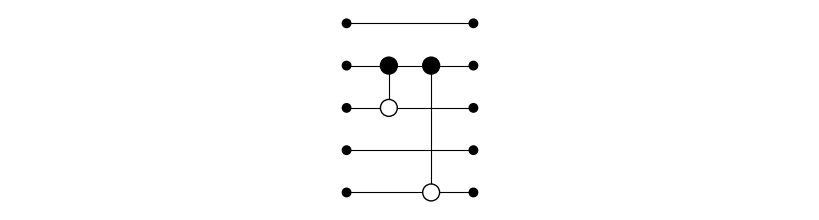

In [6]:
print(comb_decomposition.comb.matrix)
print(comb_decomposition.comb.holes)
zx.draw(comb_decomposition.comb)

In [7]:
def extract_sub_matrix(matrix, index_list):
    new_matrix = Mat2.id(len(index_list))
    for row in range(len(index_list)):
        for col in range(len(index_list)):
            new_matrix.data[col][row] = matrix.data[index_list[col]][index_list[row]]
    return new_matrix
def insert_sub_matrix(matrix, sub_matrix, index_list):
    for row in range(len(index_list)):
        for col in range(len(index_list)):
            matrix.data[index_list[col]][index_list[row]] = sub_matrix.data[col][row]
    return matrix

In [8]:
def route_general_circuit(mode, circuit, arch):
    # Decompose circuit
    comb_decomposition = CombDecomposition.from_circuit(circuit)
    comb = comb_decomposition.comb
    
    sub_circuits = []
    # Create a copy of the parity matrix of the comb to perform gaussian elimination on
    matrix = comb.matrix.copy()
    # Clear the gates of the comb, as we will generate new ones as the elimination takes place
    comb.gates = []
    # Find initial qubits for the sub matrix
    qubits_in_matrix = []
    for qubit in range(comb.qubits):
        if qubit not in comb.holes.values():
            qubits_in_matrix.append(qubit)
    #print(qubits_in_matrix)
    # Generate sub matrix
    sub_matrix = extract_sub_matrix(matrix, qubits_in_matrix)
    # Apply gaussian elimation procedure of our choosing to sub matrix
    sub_circuits.append(cnot_mapper.gauss_return_circuit(mode,
                                     sub_matrix,
                                     architecture.create_architecture(arch, n_qubits=circuit.qubits)))
    sub_matrix = sub_circuits[-1].matrix
    for gate in sub_circuits[-1].gates:
        # Add gates from sub circuit to comb circuit
        comb.gates.append(gate)
    # Place sub matrix back in large matrix
    insert_sub_matrix(matrix, sub_matrix, qubits_in_matrix)

    no_more_holes = len(comb.holes) == 0
    while not no_more_holes:
        # Update the qubits in the sub matrix to account for passing a hole
        for qubit_loc, qubit in enumerate(qubits_in_matrix):
            if qubit in comb.holes:
                qubits_in_matrix[qubit_loc] = comb.holes.pop(qubit)
        #print(qubits_in_matrix)
        if len(comb.holes) == 0:
            no_more_holes = True
        # Generate sub matrix
        sub_matrix = extract_sub_matrix(matrix, qubits_in_matrix)
        # Apply gaussian elimation procedure of our choosing to sub matrix
        sub_circuits.append(cnot_mapper.gauss_return_circuit(MODE,
                                         sub_matrix,
                                         architecture.create_architecture(arch, n_qubits=circuit.qubits)))
        sub_matrix = sub_circuits[-1].matrix
        # Convert the gates of the sub matrix using the mapping
        for gate in sub_circuits[-1].gates:
            gate.control = qubits_in_matrix[gate.control]
            gate.target = qubits_in_matrix[gate.target]
            # Add gates from sub circuit to comb circuit
            comb.gates.append(gate)
        # Place sub matrix back in large matrix
        insert_sub_matrix(matrix, sub_matrix, qubits_in_matrix)
    # The comb has now been regenerated under the constraints of the hardware topology
    # Need to recombine the comb with its hole plugs to create a new circuit
    return CombDecomposition.to_circuit(comb_decomposition)

In [9]:
MODE = cnot_mapper.GAUSS
ARCHITECTURE = architecture.FULLY_CONNNECTED
new_circuit = route_general_circuit(MODE, old_circuit, ARCHITECTURE)

2
2


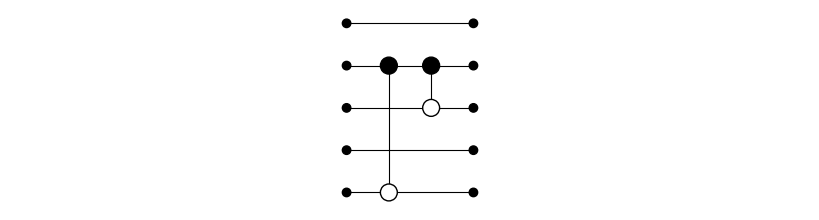

In [10]:
print(len(new_circuit.gates))
print(len(old_circuit.gates))
zx.draw(old_circuit)
zx.draw(new_circuit)

In [11]:
#g = new_circuit.to_graph()
#full_reduce(g)
#zx.draw(Circuit.from_graph(g))

In [12]:
new_circuit.verify_equality(old_circuit)

True

Test routing methods on usual circuit, not combs

In [13]:
# Import Circuits for a given number of Qubits
NUM_OF_QUBITS = 5
ARCHITECHURE = architecture.FULLY_CONNNECTED
circuits = {}
for C in read_circuits("steiner", NUM_OF_QUBITS, parity_map=True)[0]:
    if len(C.gates) not in circuits.keys():
        circuits[len(C.gates)] = [C]
    else:
        circuits[len(C.gates)].append(C)

In [14]:
print(f"{NUM_OF_QUBITS} Qubit Circuits")
for num_of_gates in circuits:
    print(f"{num_of_gates} CNOTs")
    equality = 0
    inequality = 0
    for circuit in circuits[num_of_gates]:
        if circuit.verify_equality(route_general_circuit(MODE, circuit, ARCHITECTURE)):
            equality += 1
        else:
            inequality += 1
    print(f"Equality : {equality}")
    print(f"Inequality : {inequality}")

5 Qubit Circuits
8 CNOTs
Equality : 100
Inequality : 0
15 CNOTs
Equality : 100
Inequality : 0
4 CNOTs
Equality : 100
Inequality : 0
10 CNOTs
Equality : 100
Inequality : 0
2 CNOTs
Equality : 100
Inequality : 0
20 CNOTs
Equality : 100
Inequality : 0
5 CNOTs
Equality : 100
Inequality : 0
